<a href="https://colab.research.google.com/github/krishnarevi/Attention_model_from_scratch/blob/main/Product_search_relavance_prediction_WANDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib_venn import venn2
import regex as re
from collections import Counter
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from collections import Counter
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud, STOPWORDS 
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from scipy.stats import spearmanr



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:


# mount g-drive to access datafiles
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path= '/content/drive/MyDrive/data'

In [95]:
# get search queries
query_df = pd.read_csv(path+r"/query.csv", sep='\t')
query_df.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [96]:
# get products
product_df = pd.read_csv(path+r"/product.csv", sep='\t')
product_df.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [97]:
# get manually labeled groundtruth lables
label_df = pd.read_csv(path+r"/label.csv", sep='\t')
label_df

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact
...,...,...,...,...
233443,234010,478,15439,Partial
233444,234011,478,451,Partial
233445,234012,478,30764,Irrelevant
233446,234013,478,16796,Partial


In [98]:
#Checking for null values 
print(product_df.isna().sum())
print(label_df.isna().sum())
print(query_df.isna().sum())

product_id                0
product_name              0
product_class          2852
category hierarchy     1556
product_description    6008
product_features          0
rating_count           9452
average_rating         9452
review_count           9452
dtype: int64
id            0
query_id      0
product_id    0
label         0
dtype: int64
query_id       0
query          0
query_class    6
dtype: int64


In [99]:
print("shape of label_df is {} ".format(label_df.shape))
print("shape of query_df is {} ".format(query_df.shape))
print("shape of product_df is {} ".format(product_df.shape))

shape of label_df is (233448, 4) 
shape of query_df is (480, 3) 
shape of product_df is (42994, 9) 


###EDA Labels

In [100]:
label_df['label'].value_counts()

Partial       146633
Irrelevant     61201
Exact          25614
Name: label, dtype: int64

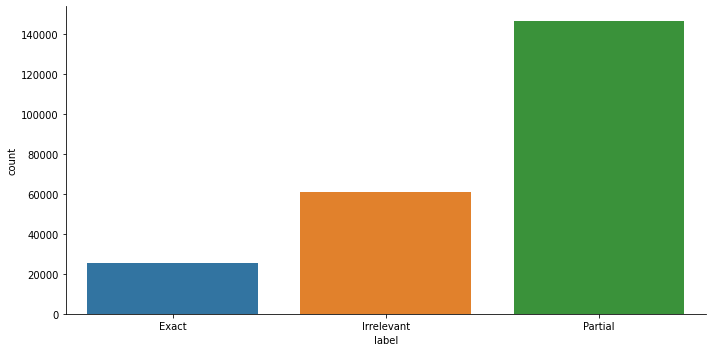

In [101]:
sns.catplot(x='label', kind='count', data=label_df, height=5, aspect=2)
plt.show()



*   Majority of product had a partial relevance  i.e most of the products are partially relevant.
* We will solve this as a classification problem because that will help us in ranking our products easily. 
* Fewer items had irrelevant lables,Very few products had exact match
* There is a class imbalance present in the data






###EDA Product_uid

max times a product has occured 46
min times a product has occured 1
Total number of unique products 42986



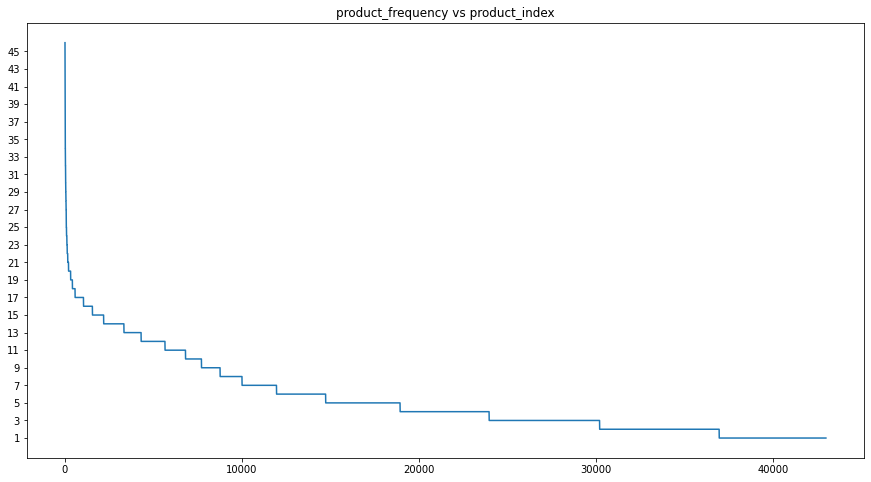

In [102]:


prod_counts=label_df['product_id'].value_counts()
print('max times a product has occured', max(prod_counts))
print('min times a product has occured', min(prod_counts))
print('Total number of unique products', len(prod_counts))
print('')

plt.figure(figsize=(15,8))
plt.title('product_frequency vs product_index')
plt.plot(prod_counts.values)
plt.yticks(np.arange(min(prod_counts.values), max(prod_counts.values)+1, 2.0))
plt.show()



There are more than 35000 products that occur multiple times i.e we have multiple search queries for the same product and corresponding relevance label for them 

###Merging the product_df, label_df and query_df

In [103]:
temp_df = pd.merge(label_df, query_df, on='query_id', how='left')
temp_df = temp_df.reset_index(drop=True)
temp_df

,id,query_id,product_id,label,query,query_class
0,0,0,25434,Exact,salon chair,Massage Chairs
1,1,0,12088,Irrelevant,salon chair,Massage Chairs
2,2,0,42931,Exact,salon chair,Massage Chairs
3,3,0,2636,Exact,salon chair,Massage Chairs
4,4,0,42923,Exact,salon chair,Massage Chairs
...,...,...,...,...,...,...
233443,234010,478,15439,Partial,worn leather office chair,Office Chairs
233444,234011,478,451,Partial,worn leather office chair,Office Chairs
233445,234012,478,30764,Irrelevant,worn leather office chair,Office Chairs
233446,234013,478,16796,Partial,worn leather office chair,Office Chairs


In [104]:
temp_df.isna().sum()

id               0
query_id         0
product_id       0
label            0
query            0
query_class    328
dtype: int64

In [105]:
final_df = pd.merge(temp_df, product_df, on='product_id', how='left')
final_df = final_df.reset_index(drop=True)
final_df


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,0,25434,Exact,salon chair,Massage Chairs,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
1,1,0,12088,Irrelevant,salon chair,Massage Chairs,22.5 '' wide polyester side chair,Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,add a beautiful accent to any room with this m...,overalldepth-fronttoback:27.5|design : side ch...,NaN,NaN,NaN
2,2,0,42931,Exact,salon chair,Massage Chairs,24.4 '' w metal lounge chair with metal frame,Reception Seating Chairs,Shop Product Type / Chairs / Guest & Reception...,the heavy duty barber chair is built to last ....,color : black|seatcushionorupholsteryfillmater...,1.0,4.0,0.0
3,3,0,2636,Exact,salon chair,Massage Chairs,25 '' wide faux leather manual swivel standard...,Recliners,Furniture / Living Room Furniture / Chairs & S...,this is a chair designed for your barbershop ....,design : standard recliner|warrantylength:60 d...,5.0,5.0,3.0
4,4,0,42923,Exact,salon chair,Massage Chairs,27.6 '' w antimicrobial leather seat waiting r...,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,NaN,backupholsterymaterial : leather|armsincluded ...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233443,234010,478,15439,Partial,worn leather office chair,Office Chairs,fellsburg linen upholstered parsons chair,Accent Chairs|Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,NaN,numberofchairsincluded:4|legmaterial : solid w...,1729.0,4.0,1193.0
233444,234011,478,451,Partial,worn leather office chair,Office Chairs,olin upholstered side chair,Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,if you are looking for a simple yet sleek dini...,productcare : wipe with damp cloth|legcolor : ...,2880.0,4.5,1921.0
233445,234012,478,30764,Irrelevant,worn leather office chair,Office Chairs,barbay lounge chair cushion,Furniture Cushions,NaN,NaN,durability : mildew resistant|furnituretype : ...,74.0,4.5,51.0
233446,234013,478,16796,Partial,worn leather office chair,Office Chairs,haings upholstered parsons chair,Accent Chairs|Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,this set of 2 armless side chairs boasts an up...,dssecondaryproductstyle : transitional traditi...,50.0,4.5,39.0


In [106]:
final_df.shape

(233448, 14)

In [ ]:
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname,
                                         frac_train=0.9,frac_test=0.1,
                                         random_state=7):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train +  frac_test != 1.0:
        raise ValueError('fractions %f, %f do not add up to 1.0' % \
                         (frac_train,  frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    # relative_frac_test = frac_test / (frac_val + frac_test)
    # df_val, df_test, y_val, y_test = train_test_split(df_temp,
    #                                                   y_temp,
    #                                                   stratify=y_temp,
    #                                                   test_size=relative_frac_test,
    #                                                   random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_test)

    return df_train, df_test
ag_train, ag_test=split_stratified_into_train_val_test(data, stratify_colname='Intent')

In [107]:
temp_d =final_df.copy()

In [108]:
temp_d.isna().sum()

id                         0
query_id                   0
product_id                 0
label                      0
query                      0
query_class              328
product_name               0
product_class          17963
category hierarchy      7071
product_description    30784
product_features           0
rating_count           52718
average_rating         52718
review_count           52718
dtype: int64

### Cleaning product features
product_features column has | delimited string of attribute:value pairs which describe the product. Attributes seems to be clustered without space between words. As a quick workaround , we can omit attributes and select only value part for further processing.
As a future step we can try including attributes as well after extensive cleaning

In [109]:
temp_d['product_features'] = temp_d['product_features'].str.split('|')

In [110]:
temp_d['product_features'][0]

['backupholsterycolor : champagne',
 'primarymaterial : wood',
 'seatupholsterycolor : champagne',
 'color : champagne',
 'seatmaterial : leather',
 'backmaterial : leather',
 'weightcapacity:330',
 'dsmetallic : iron',
 'framematerial : wood',
 'armsincluded : with arms',
 'overallwidth-sidetoside:21.7',
 'backupholsterymaterial : leather',
 'overallheight-toptobottom:34.6',
 'warrantylength:1 year',
 'overallproductweight:55',
 'backtype : upholstered',
 'supplierintendedandapproveduse : non residential use',
 'producttype : waiting room chair',
 'seatmaterial : wood',
 'overalldepth-fronttoback:30.9',
 'seatupholsterymaterial : leather',
 'framematerialdetails : stainless steel',
 'seatingcapacity:1',
 'adacompliant : no',
 'oeko-texcertified : no',
 ' : no',
 'caltb117-2013compliant : no',
 'taacompliant : no',
 'casters : no',
 'gsaapproved : no',
 'compositewoodproductcwp : no',
 'calgreencompliant : no',
 'ansisohos65smallofficehomeoffice : no',
 'antimicrobial : no',
 'caltb116

In [111]:

def preprocess_pf(x):
  regexp = re.compile(":(.*)$")

  k = [regexp.search(s).group(1).strip() for s in x if regexp.search(s) ]
  cleaned =list(set(k))
  cleaned = ' '.join(map(str, cleaned))
  
  return cleaned
temp_d['product_features'] = temp_d['product_features'].apply(lambda x:preprocess_pf(x)) 

In [112]:
temp_d['product_features'][100]


"double wheel metal 23.5 200 lbs - 249 lbs 20 non residential use residential use 15 245 partial assembly 14.5 iron tile carpet 19.5 white linoleum medium usage ( up to 8 hours ) modern china 1 clean it with a slightly damp cloth 1 year chromed foam 28 8.5 mid-century modern warranty only for manufacturer 's defects yes no seat hardwood no natural variation task chair other upholstered all tools included no distressing 16 pu leather limited faux leather 23.2 32 black"

###Missing value imputation

In [113]:
temp_d['rating_count'] = temp_d['rating_count'].fillna(0)
temp_d['average_rating'] = temp_d['average_rating'].fillna(0)
temp_d['review_count'] = temp_d['review_count'].fillna(0)

####Missing value immputation: query class
For query_class we will be filling the missing values from query as we will see both query_class and query are very similar

In [114]:
null_df = temp_d[temp_d['query_class'].isnull()]

In [115]:
null_df['query_class'] = null_df['query'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
temp_d['query_class'].loc[null_df.index] = null_df['query'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [117]:
for col in temp_d.columns:
  print('{} has {} null values'.format(col, temp_d[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 17963 null values
category hierarchy has 7071 null values
product_description has 30784 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


####Missing value immputation: product_class
For product_class we will be filling the missing values from product_name as we will see both product_class and product_name are very similar

In [118]:
null_d = temp_d[temp_d['product_class'].isnull()]

In [119]:
null_d['product_class'] = null_d['product_name'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
temp_d['product_class'].loc[null_d.index] = null_d['product_name'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [121]:
for col in temp_d.columns:
  print('{} has {} null values'.format(col, temp_d[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 7071 null values
product_description has 30784 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


####Missing value immputation: categorical hierarchy
Check if category hierarchy is available for any product that belongs to same class. If yes, we will replace with those values

In [122]:
unique_products = np.unique(temp_d['product_class'].dropna().values)
print('Number of unique product classes', len(unique_products))

Number of unique product classes 3707


In [123]:
null_df = temp_d[temp_d['category hierarchy'].isnull()]
notnull_df = temp_d.dropna()


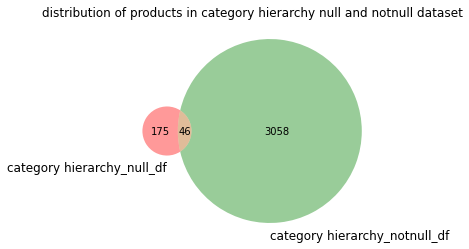

In [124]:
set1 = set(null_df['product_class'].values)
set2 = set(notnull_df['product_class'].values)

venn2([set1, set2], ('category hierarchy_null_df', 'category hierarchy_notnull_df'))
plt.title('distribution of products in category hierarchy null and notnull dataset')
plt.show()

There are some unique product classes that are present in both data sets where category hierarchy value is null and not null. So, we can use this to replace null values in category hierarchy column

In [125]:
category_dict = dict(zip(notnull_df['product_class'], notnull_df['category hierarchy']))

In [126]:
null_df['category hierarchy']=null_df['product_class'].map(category_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [127]:
temp_d['category hierarchy'].loc[null_df.index] = null_df['category hierarchy'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [128]:
for col in temp_d.columns:
  print('{} has {} null values'.format(col, temp_d[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 719 null values
product_description has 30784 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


Now we can see our category hierarchy null values went down from 7071 to 719.
Remaining null values we will replace with product class itself.

In [129]:
null_df = temp_d[temp_d['category hierarchy'].isnull()]

In [130]:
null_df['category hierarchy'] = null_df['product_class'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [131]:
temp_d['category hierarchy'].loc[null_df.index] = null_df['category hierarchy'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [132]:
for col in temp_d.columns:
  print('{} has {} null values'.format(col, temp_d[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 0 null values
product_description has 30784 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


####Missing value immputation: product_description
For product_description we will be filling the missing values from product_features as we will see both product_description and product_features are similar

In [133]:
null_df = temp_d[temp_d['product_description'].isnull()]

In [134]:
null_df[' product_description'] = null_df['product_features'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [135]:
temp_d['product_description'].loc[null_df.index] = null_df['product_features'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [136]:
for col in temp_d.columns:
  print('{} has {} null values'.format(col, temp_d[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 0 null values
product_description has 0 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values



####Comparing product_description and product_features

In [137]:


temp_d['product_description'][40] 



'modern and glam , this desk chair is just what your home office needs . it showcases an open back with a soft seat cushion . this chair is upholstered in velvet for a glam look and is available in a variety of solid hues to go with your existing color palette . down below , five metal legs in a finish are capped off with casters that help you move from task to task with ease . it is suitable for most of your work scenarios such as study room , bedroom , office .'

In [138]:
temp_d['product_features'][40] 

'rose double wheel velvet metal teal 16.9 concrete residential use 15 full assembly needed 33.5 250 dark blue tile carpet fixed allmodern 17.3 linoleum medium usage ( up to 8 hours ) modern canary china 1 1 year foam 32.9 cactus back blush mid-century modern yes no seat 16.1 chrome hardwood no natural variation task chair 11.6 all tools included upholstered 250 lbs - 299 lbs wipe with a damp cloth no distressing steel limited black 24.4'

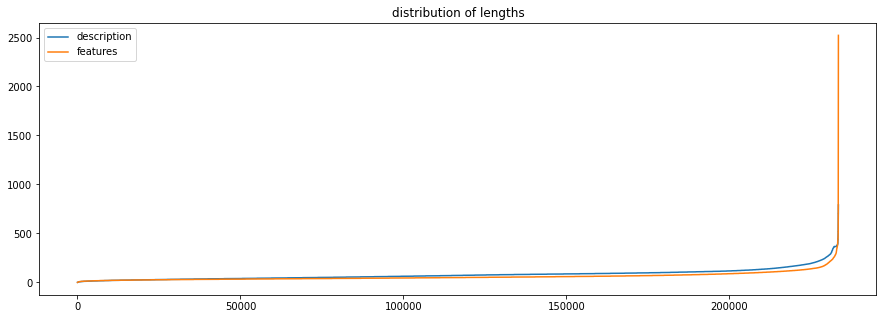

In [139]:
temp_df = temp_d[['product_features','product_description']]
len_desc = temp_df['product_description'].apply(lambda x : len(x.split()))
len_feature = temp_df['product_features'].apply(lambda x : len(x.split()))

plt.figure(figsize=(15,5))
plt.plot(np.sort(len_desc.values),label="description")
plt.plot(np.sort(len_feature.values),label="features")
plt.title('distribution of lengths')
plt.legend()
plt.show()

On close inspection we see that product description and  product features are very similar texts. We will explore them more after data cleaning.

## Cleaning of text data

In [140]:
temp_d.head()


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,0,25434,Exact,salon chair,Massage Chairs,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",non residential use residential use iron stain...,0.0,0.0,0.0
1,1,0,12088,Irrelevant,salon chair,Massage Chairs,22.5 '' wide polyester side chair,Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,add a beautiful accent to any room with this m...,22.5 side chair 20 black rubberwood stain resi...,0.0,0.0,0.0
2,2,0,42931,Exact,salon chair,Massage Chairs,24.4 '' w metal lounge chair with metal frame,Reception Seating Chairs,Shop Product Type / Chairs / Guest & Reception...,the heavy duty barber chair is built to last ....,metal 34.3 residential use 18 screw driver chi...,1.0,4.0,0.0
3,3,0,2636,Exact,salon chair,Massage Chairs,25 '' wide faux leather manual swivel standard...,Recliners,Furniture / Living Room Furniture / Chairs & S...,this is a chair designed for your barbershop ....,x : clean by lightly brushing and/or vacuuming...,5.0,5.0,3.0
4,4,0,42923,Exact,salon chair,Massage Chairs,27.6 '' w antimicrobial leather seat waiting r...,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,metal 20 38.2 residential use iron waiting roo...,metal 20 38.2 residential use iron waiting roo...,0.0,0.0,0.0


In [141]:


def unit_counts(column):
  words = ' '.join(temp_d[column].unique()).split()
  units = ['feet', 'foot','ft.','fathom', 'fm','fm.','inches', 'inchs','in', 'inch','in.', 'centi','cm.' ,'yd.', 'yd','yard', 'yds',
          'ac', 'ac.' , 'acre', 'sq', 'square', 'sq.', 'lb', 'lb.','lbs', 'pound', 'pounds','oz', 'ozs', 'ounce', 'ounces', 'oz.',
          'g', 'gram', 'gr', 'mg', 'st', 'st.', 'stone', 'kg', 'tsp', 'g.', 'tbsp', 'qt', 'ml', 'ml.', 'l',  'l', 'litre','pt', 
          'pt.', 'gal', 'gals', 'gallon', 'gallons','galons', 'gals.','gal.', 'mph', 'cal', 'kn','metre', 'm', 'cm', 'km']
  counts = {}
  for unit in units:
    cnt = list(words).count(unit)
    counts[unit] = cnt
  return counts



In [142]:
print(unit_counts('product_description'))
print(unit_counts('product_features'))
print(unit_counts('product_name'))
print(unit_counts('query'))
print(unit_counts('query_class'))

{'feet': 1418, 'foot': 487, 'ft.': 303, 'fathom': 0, 'fm': 0, 'fm.': 0, 'inches': 794, 'inchs': 4, 'in': 35863, 'inch': 256, 'in.': 6, 'centi': 0, 'cm.': 0, 'yd.': 0, 'yd': 0, 'yard': 243, 'yds': 0, 'ac': 52, 'ac.': 0, 'acre': 0, 'sq': 27, 'square': 1793, 'sq.': 0, 'lb': 109, 'lb.': 0, 'lbs': 807, 'pound': 32, 'pounds': 198, 'oz': 59, 'ozs': 0, 'ounce': 4, 'ounces': 20, 'oz.': 0, 'g': 6, 'gram': 0, 'gr': 0, 'mg': 0, 'st': 0, 'st.': 5, 'stone': 796, 'kg': 56, 'tsp': 2, 'g.': 1, 'tbsp': 1, 'qt': 57, 'ml': 7, 'ml.': 0, 'l': 373, 'litre': 0, 'pt': 0, 'pt.': 0, 'gal': 13, 'gals': 2, 'gallon': 45, 'gallons': 47, 'galons': 0, 'gals.': 0, 'gal.': 0, 'mph': 2, 'cal': 13, 'kn': 0, 'metre': 0, 'm': 17, 'cm': 196, 'km': 0}
{'feet': 139, 'foot': 68, 'ft.': 1249, 'fathom': 0, 'fm': 0, 'fm.': 0, 'inches': 939, 'inchs': 0, 'in': 13615, 'inch': 43, 'in.': 36, 'centi': 0, 'cm.': 0, 'yd.': 0, 'yd': 0, 'yard': 6, 'yds': 0, 'ac': 34, 'ac.': 0, 'acre': 0, 'sq': 3, 'square': 4292, 'sq.': 0, 'lb': 11, 'lb.': 





*  In lots of product_name, dimensions of products are mentioned. A very common way of representing them is like '8 ft. x 5 ft. x 8 ft.' with whitespaces in between. The same is observed in product_description and features.
    In product_name units are mostly represented as (in. ft. square lbs. oz. gallon. l) but in product_description and query units are represented in multiple ways for example inch as (in. in inch) hence these need to be standardized.

*       Also, in query, there were some common errors when specifying measurements. Some examples are '7qt', '54 in', '36"'Hence we need to seperate numbers from letters.


### cleaning



1.   Seperate numbers from words: "9x12" -> "9 x 12" , "5gal" -> "5 gal" ...

2.   Bring all units of measurements to a consistent representation.






In [143]:

#We are not including units (ft. lb. sq. ...) as the full stop will be taken care by 
#the re.split(r'\W+', sent) function in the preprocessing function

#In description and name, 'inch' is generally found as 'in.' where as in query,
#its found both as 'in' and 'in.' thus we deal with both cases seperately. Thus a seperate 
#preprocessing function for search terms

#we are not using stemming and stopwords now. We will be stemming after correction of query

#'in.','in' to inch is taken care of in preprocessing step
#'inches' to inch will be taken care in stemming. 

stop_words = set(stopwords.words('english'))
def standardize_units(text):
  text = " " + text + " "
  text = re.sub('( gal | gals | galon )',' gallon ',text)
  text = re.sub('( ft | fts | feets | foot | foots )',' feet ',text)
  text = re.sub('( squares | sq )',' square ',text)
  text = re.sub('( lb | lbs | pounds )',' pound ',text)
  text = re.sub('( oz | ozs | ounces | ounc )',' ounce ',text)
  text = re.sub('( wide | width | w )',' width ',text)
  return text

def preprocessing(sent):
  sent = sent.replace('in.', ' inch ')#If we dont to this then 'in.' will be turned to 'in' in the next step
  sent =  re.sub(r'(\d+) \'\'', r'\1 inch', sent) #some times inch is represented in symbol
  words = re.split(r'\W+', sent)
  words = [word.lower() for word in words]
  res = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", ' '.join(words)) #add space between number and alphabets in a string
  cleaned = standardize_units(res) 
  cleaned = ' '.join(cleaned.split()) #removing extra whitespaces
  words = cleaned.split()
  words = [w for w in words if not w in stop_words]

  return ' '.join(words)

def preprocessing_search(sent):
  sent = sent.replace('in.', ' inch ')
  sent =  re.sub(r'(\d+) \'\'', r'\1 inch', sent) #some times inch is represented in symbol
  words = re.split(r'\W+', sent)
  words = [word.lower() for word in words]
  res = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", ' '.join(words)) #add space between number and alphabets in a string
  res = standardize_units(res) 
  res = res.replace(' in ', ' inch ') #in search_terms 'in' is used more for 'inch' than as a preposition hence this step shouldn't hurt
  cleaned = ' '.join(res.split()) #removing extra whitespaces
  words = cleaned.split()
  words = [w for w in words if not w in stop_words]

  return ' '.join(words)

In [144]:

temp_d['cleaned_name'] = temp_d['product_name'].apply(lambda x : preprocessing(x))
temp_d['cleaned_class'] = temp_d['product_class'].apply(lambda x : preprocessing(x))
temp_d['cleaned_description'] = temp_d['product_description'].apply(lambda x : preprocessing(x))
temp_d['cleaned_features'] = temp_d['product_features'].apply(lambda x : preprocessing(x))
temp_d['cleaned_hierarchy'] = temp_d['category hierarchy'].apply(lambda x : preprocessing(x))

#preprocessing for search is implemented in a slight different manner 
temp_d['cleaned_query'] = temp_d['query'].apply(lambda x : preprocessing_search(x))
temp_d['cleaned_query_class'] = temp_d['query_class'].apply(lambda x : preprocessing_search(x))
temp_d.head()


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,...,rating_count,average_rating,review_count,cleaned_name,cleaned_class,cleaned_description,cleaned_features,cleaned_hierarchy,cleaned_query,cleaned_query_class
0,0,0,25434,Exact,salon chair,Massage Chairs,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",...,0.0,0.0,0.0,21 7 inch width waiting room chair wood frame,waiting room chairs,salon chair barber chair hairstylist cheap cla...,non residential use residential use iron stain...,commercial business furniture commercial offic...,salon chair,massage chairs
1,1,0,12088,Irrelevant,salon chair,Massage Chairs,22.5 '' wide polyester side chair,Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,add a beautiful accent to any room with this m...,...,0.0,0.0,0.0,22 5 inch width polyester side chair,accent chairs,add beautiful accent room modern contemporary ...,22 5 side chair 20 black rubberwood stain resi...,furniture living room furniture chairs seating...,salon chair,massage chairs
2,2,0,42931,Exact,salon chair,Massage Chairs,24.4 '' w metal lounge chair with metal frame,Reception Seating Chairs,Shop Product Type / Chairs / Guest & Reception...,the heavy duty barber chair is built to last ....,...,1.0,4.0,0.0,24 4 inch width metal lounge chair metal frame,reception seating chairs,heavy duty barber chair built last offers comf...,metal 34 3 residential use 18 screw driver chi...,shop product type chairs guest reception chairs,salon chair,massage chairs
3,3,0,2636,Exact,salon chair,Massage Chairs,25 '' wide faux leather manual swivel standard...,Recliners,Furniture / Living Room Furniture / Chairs & S...,this is a chair designed for your barbershop ....,...,5.0,5.0,3.0,25 inch width faux leather manual swivel stand...,recliners,chair designed barbershop suitable haircuts ta...,x clean lightly brushing vacuuming remove dust...,furniture living room furniture chairs seating...,salon chair,massage chairs
4,4,0,42923,Exact,salon chair,Massage Chairs,27.6 '' w antimicrobial leather seat waiting r...,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,metal 20 38.2 residential use iron waiting roo...,...,0.0,0.0,0.0,27 6 inch width antimicrobial leather seat wai...,waiting room chairs,metal 20 38 2 residential use iron waiting roo...,metal 20 38 2 residential use iron waiting roo...,commercial business furniture commercial offic...,salon chair,massage chairs


In [145]:
temp_d.columns

Index(['id', 'query_id', 'product_id', 'label', 'query', 'query_class',
       'product_name', 'product_class', 'category hierarchy',
       'product_description', 'product_features', 'rating_count',
       'average_rating', 'review_count', 'cleaned_name', 'cleaned_class',
       'cleaned_description', 'cleaned_features', 'cleaned_hierarchy',
       'cleaned_query', 'cleaned_query_class'],
      dtype='object')

###Further cleaning

In [146]:


#stop word removal and stemming
#We didn't do this before because we wanted to fix the typos in the searh term first 
porter = PorterStemmer()

def stemming(sent):
  words = sent.split()
  words = [porter.stem(word) for word in words]
  return ' '.join(words)

#storing the final data in a new dataframe 'cleaned_df' 
clean_df = temp_d[['id', 'query_id', 'product_id', 'rating_count', 'average_rating', 'review_count', 'label']]
clean_df['name'] = temp_d['cleaned_name'].apply(lambda x : stemming(x))
clean_df['class'] = temp_d['cleaned_class'].apply(lambda x : stemming(x))
clean_df['description'] = temp_d['cleaned_description'].apply(lambda x : stemming(x))
clean_df['features'] = temp_d['cleaned_features'].apply(lambda x : stemming(x))
clean_df['hierarchy'] = temp_d['cleaned_hierarchy'].apply(lambda x : stemming(x))

#stemming for search is implemented in a slight different manner 
clean_df['query'] = temp_d['cleaned_query'].apply(lambda x : stemming(x))
clean_df['query_class'] = temp_d['cleaned_query_class'].apply(lambda x : stemming(x))
clean_df.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,id,query_id,product_id,rating_count,average_rating,review_count,label,name,class,description,features,hierarchy,query,query_class
0,0,0,25434,0.0,0.0,0.0,Exact,21 7 inch width wait room chair wood frame,wait room chair,salon chair barber chair hairstylist cheap cla...,non residenti use residenti use iron stainless...,commerci busi furnitur commerci offic furnitur...,salon chair,massag chair
1,1,0,12088,0.0,0.0,0.0,Irrelevant,22 5 inch width polyest side chair,accent chair,add beauti accent room modern contemporari acc...,22 5 side chair 20 black rubberwood stain resi...,furnitur live room furnitur chair seat accent ...,salon chair,massag chair
2,2,0,42931,1.0,4.0,0.0,Exact,24 4 inch width metal loung chair metal frame,recept seat chair,heavi duti barber chair built last offer comfo...,metal 34 3 residenti use 18 screw driver china...,shop product type chair guest recept chair,salon chair,massag chair
3,3,0,2636,5.0,5.0,3.0,Exact,25 inch width faux leather manual swivel stand...,reclin,chair design barbershop suitabl haircut tattoo...,x clean lightli brush vacuum remov dust metal ...,furnitur live room furnitur chair seat reclin,salon chair,massag chair
4,4,0,42923,0.0,0.0,0.0,Exact,27 6 inch width antimicrobi leather seat wait ...,wait room chair,metal 20 38 2 residenti use iron wait room cha...,metal 20 38 2 residenti use iron wait room cha...,commerci busi furnitur commerci offic furnitur...,salon chair,massag chair


In [147]:
map_dict = {'Exact':1,'Partial':2,'Irrelevant':3}
clean_df['target'] = clean_df['label'].map(map_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [148]:
clean_df['target'].value_counts()


2    146633
3     61201
1     25614
Name: target, dtype: int64

In [149]:
clean_df.to_excel(path+r'clean_df.xlsx',index=False)
# clean_df2.to_excel(path+r'clean_df2',index=False)


### Feature Engineering

In [4]:


import math
import re
import xgboost as xgb
from xgboost import XGBClassifier
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
import pickle
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Features set 1


*   Common words and their count between query,query class and document fields (name, description, features)

*   Cosine coefficient, jacquard coefficient between query and document fields
*   Whether the last word in query is in text fields

*   Length of the query

*   Lengths of document fields 





Creating the Features

In [9]:


# data1 = clean_df.copy()

data1 = pd.read_excel(path+r'clean_df.xlsx')


AttributeError: ignored

In [10]:
data1.isnull().sum()

id                0
query_id          0
product_id        0
rating_count      0
average_rating    0
review_count      0
label             0
name              0
class             0
description       0
features          5
hierarchy         0
query             0
query_class       0
target            0
dtype: int64

In [11]:
data1 = data1.dropna().reset_index(drop=True)

Common words

In [12]:
def common_words(df, col1, col2):
  """
  Returns common words between each row of col1 and col2 of df in the form of a list. 
  Length of list is number of rows in dataframe
  """
  common_list = []
  for i, row in df[[col1,col2]].iterrows():
    set1 = set(row[col1].split())
    set2 = set(row[col2].split())
    common = set1 & set2
    common = ' '.join(common)
    common_list.append(common)
  return common_list

In [13]:
data1['common_SN'] = common_words(data1,'query', 'name')
data1['common_SD'] = common_words(data1,'query', 'description')
data1['common_SF'] = common_words(data1,'query', 'features')
data1['common_SH'] = common_words(data1,'query', 'hierarchy')
data1['common_SC'] = common_words(data1,'query', 'class')

data1['common_QC_SN'] = common_words(data1,'query_class', 'name')
data1['common_QC_SD'] = common_words(data1,'query_class', 'description')
data1['common_QC_SF'] = common_words(data1,'query_class', 'features')
data1['common_QC_SH'] = common_words(data1,'query_class', 'hierarchy')
data1['common_QC_SC'] = common_words(data1,'query_class', 'class')


data1['num_common_SN'] = data1['common_SN'].apply(lambda x : len(x.split()))
data1['num_common_SD'] = data1['common_SD'].apply(lambda x : len(x.split()))
data1['num_common_SF'] = data1['common_SF'].apply(lambda x : len(x.split()))
data1['num_common_SH'] = data1['common_SH'].apply(lambda x : len(x.split()))
data1['num_common_SC'] = data1['common_SC'].apply(lambda x : len(x.split()))

data1['num_common_QC_SN'] = data1['common_SN'].apply(lambda x : len(x.split()))
data1['num_common_QC_SD'] = data1['common_SD'].apply(lambda x : len(x.split()))
data1['num_common_QC_SF'] = data1['common_SF'].apply(lambda x : len(x.split()))
data1['num_common_QC_SH'] = data1['common_SH'].apply(lambda x : len(x.split()))
data1['num_common_QC_SC'] = data1['common_SC'].apply(lambda x : len(x.split()))


In [14]:
def cosine_similarity_sent(sent1, sent2):
  """
  Cosine Similarity between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = math.sqrt(len(set1)) * math.sqrt(len(set2))
  
  if not denominator:
      return 0.0
  else:
      return numerator / denominator

def jacquard_coefficient_sent(sent1, sent2):
  """
  Jacquard Coefficient between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = len(set1 | set2)

  if not denominator:
      return 0.0
  else:
      return numerator / denominator

More similarity checks

In [15]:


#COSINE COEFFICIENT
data1['cosine_SN'] = data1.apply(lambda row: cosine_similarity_sent(row['query'], row['name']), axis=1) 
data1['cosine_SD'] = data1.apply(lambda row: cosine_similarity_sent(row['query'], row['description']), axis=1)
data1['cosine_SF'] = data1.apply(lambda row: cosine_similarity_sent(row['query'], row['features']), axis=1)
data1['cosine_SH'] = data1.apply(lambda row: cosine_similarity_sent(row['query'], row['hierarchy']), axis=1) 
data1['cosine_SC'] = data1.apply(lambda row: cosine_similarity_sent(row['query'], row['class']), axis=1)

#JACQUARD COEFFICIENT
data1['jacquard_SN'] = data1.apply(lambda row: jacquard_coefficient_sent(row['query'], row['name']), axis=1) 
data1['jacquard_SD'] = data1.apply(lambda row: jacquard_coefficient_sent(row['query'], row['description']), axis=1)
data1['jacquard_SF'] = data1.apply(lambda row: jacquard_coefficient_sent(row['query'], row['features']), axis=1)
data1['jacquard_SH'] = data1.apply(lambda row: jacquard_coefficient_sent(row['query'], row['hierarchy']), axis=1) 
data1['jacquard_SC'] = data1.apply(lambda row: jacquard_coefficient_sent(row['query'], row['class']), axis=1)
#COSINE COEFFICIENT for query class
data1['cosine_QC_SN'] = data1.apply(lambda row: cosine_similarity_sent(row["query_class"], row['name']), axis=1) 
data1['cosine_QC_SD'] = data1.apply(lambda row: cosine_similarity_sent(row["query_class"], row['description']), axis=1)
data1['cosine_QC_SF'] = data1.apply(lambda row: cosine_similarity_sent(row["query_class"], row['features']), axis=1)
data1['cosine_QC_SH'] = data1.apply(lambda row: cosine_similarity_sent(row["query_class"], row['hierarchy']), axis=1) 
data1['cosine_QC_SC'] = data1.apply(lambda row: cosine_similarity_sent(row["query_class"], row['class']), axis=1)


#JACQUARD COEFFICIENT for query class
data1['jacquard_QC_SN'] = data1.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['name']), axis=1) 
data1['jacquard_QC_SD'] = data1.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['description']), axis=1)
data1['jacquard_QC_SF'] = data1.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['features']), axis=1)
data1['jacquard_QC_SH'] = data1.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['hierarchy']), axis=1) 
data1['jacquard_QC_SC'] = data1.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['class']), axis=1)



Length of document fields

In [16]:
data1['len_description'] = data1['description'].apply(lambda x : len(x.split()))
data1['len_features'] = data1['features'].apply(lambda x : len(x.split()))
data1['len_name'] = data1['name'].apply(lambda x : len(x.split()))
data1['len_class'] = data1['class'].apply(lambda x : len(x.split()))
data1['len_hierarchy'] = data1['hierarchy'].apply(lambda x : len(x.split()))

data1['len_query'] = data1['query'].apply(lambda x : len(x.split()))
data1['len_query_class'] = data1['query_class'].apply(lambda x : len(x.split()))

Presenece of last word from query in document field

In [17]:


#last term
data1['islast_SN'] = data1.apply(lambda row: row['query'].split()[-1] in row['name'].split(), axis=1)
data1['islast_SD'] = data1.apply(lambda row: row['query'].split()[-1] in row['description'].split(), axis=1)
data1['islast_SF'] = data1.apply(lambda row: row['query'].split()[-1] in row['features'].split(), axis=1)
data1['islast_SH'] = data1.apply(lambda row: row['query'].split()[-1] in row['hierarchy'].split(), axis=1)
data1['islast_SC'] = data1.apply(lambda row: row['query'].split()[-1] in row['class'].split(), axis=1)




In [18]:
data1.columns


Index(['id', 'query_id', 'product_id', 'rating_count', 'average_rating',
       'review_count', 'label', 'name', 'class', 'description', 'features',
       'hierarchy', 'query', 'query_class', 'target', 'common_SN', 'common_SD',
       'common_SF', 'common_SH', 'common_SC', 'common_QC_SN', 'common_QC_SD',
       'common_QC_SF', 'common_QC_SH', 'common_QC_SC', 'num_common_SN',
       'num_common_SD', 'num_common_SF', 'num_common_SH', 'num_common_SC',
       'num_common_QC_SN', 'num_common_QC_SD', 'num_common_QC_SF',
       'num_common_QC_SH', 'num_common_QC_SC', 'cosine_SN', 'cosine_SD',
       'cosine_SF', 'cosine_SH', 'cosine_SC', 'jacquard_SN', 'jacquard_SD',
       'jacquard_SF', 'jacquard_SH', 'jacquard_SC', 'cosine_QC_SN',
       'cosine_QC_SD', 'cosine_QC_SF', 'cosine_QC_SH', 'cosine_QC_SC',
       'jacquard_QC_SN', 'jacquard_QC_SD', 'jacquard_QC_SF', 'jacquard_QC_SH',
       'jacquard_QC_SC', 'len_description', 'len_features', 'len_name',
       'len_class', 'len_hierarchy', 'le

In [19]:
#converting all the boolean column to int
bool_cols = ['islast_SN', 'islast_SD', 'islast_SF', 'islast_SH', 'islast_SC']
for col in bool_cols:
  data1[col] = data1[col].astype(int)

EDA on Feature set so far

In [20]:

feat_set1=['rating_count', 'average_rating',
       'review_count', 'num_common_SN',
       'num_common_SD', 'num_common_SF', 'num_common_SH', 'num_common_SC',
       'num_common_QC_SN', 'num_common_QC_SD', 'num_common_QC_SF',
       'num_common_QC_SH', 'num_common_QC_SC', 'cosine_SN', 'cosine_SD',
       'cosine_SF', 'cosine_SH', 'cosine_SC', 'jacquard_SN', 'jacquard_SD',
       'jacquard_SF', 'jacquard_SH', 'jacquard_SC', 'cosine_QC_SN',
       'cosine_QC_SD', 'cosine_QC_SF', 'cosine_QC_SH', 'cosine_QC_SC',
       'jacquard_QC_SN', 'jacquard_QC_SD', 'jacquard_QC_SF', 'jacquard_QC_SH',
       'jacquard_QC_SC', 'len_description', 'len_features', 'len_name',
       'len_class', 'len_hierarchy', 'len_query', 'len_query_class',
       'islast_SN', 'islast_SD', 'islast_SF', 'islast_SH', 'islast_SC']
eda_df1 = data1[feat_set1]
eda_df1['label'] = data1['label']
eda_df=eda_df1.copy()
eda_df['target']=data1['target']
eda_df1.head(1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,rating_count,average_rating,review_count,num_common_SN,num_common_SD,num_common_SF,num_common_SH,num_common_SC,num_common_QC_SN,num_common_QC_SD,...,len_class,len_hierarchy,len_query,len_query_class,islast_SN,islast_SD,islast_SF,islast_SH,islast_SC,label
0,0,0.0,0,1,2,1,1,1,1,2,...,3,15,2,2,1,1,1,1,1,Exact


### PDFS FOR EACH FEATURE

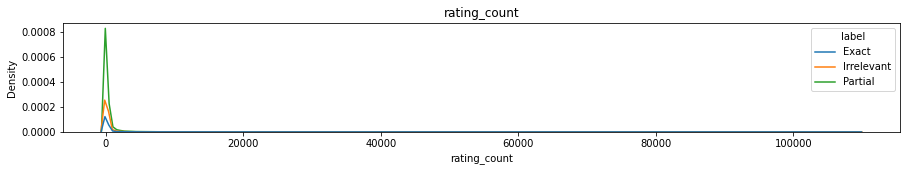

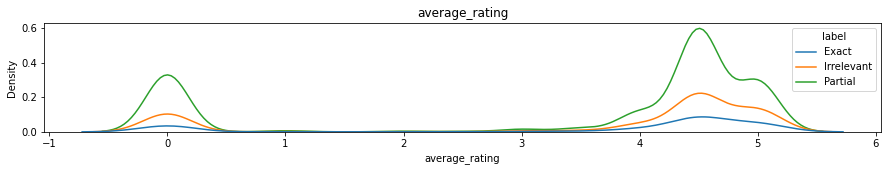

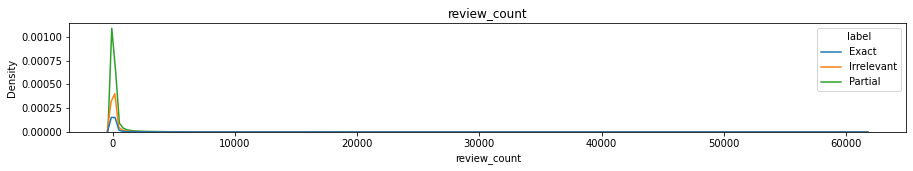

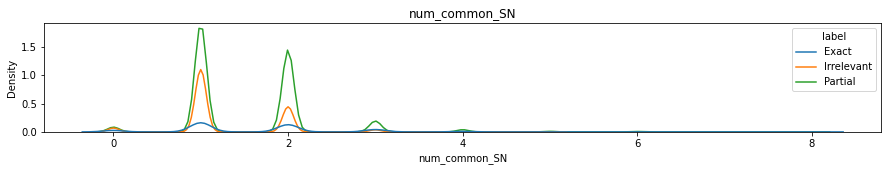

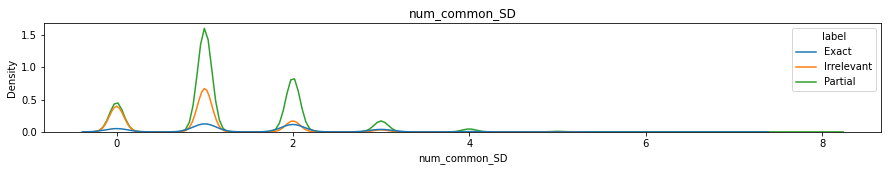

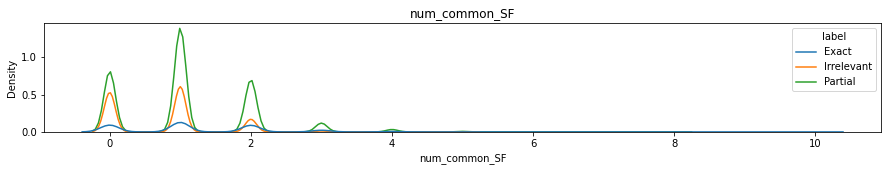

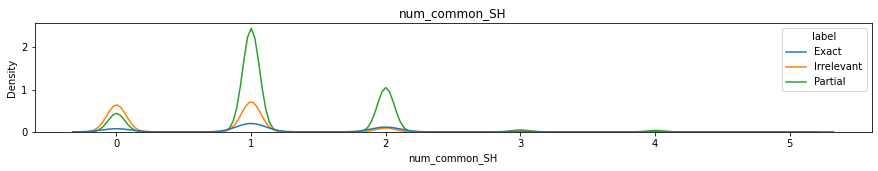

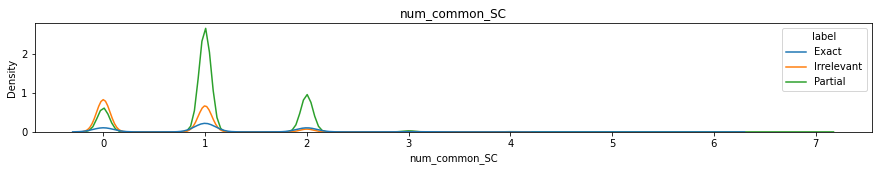

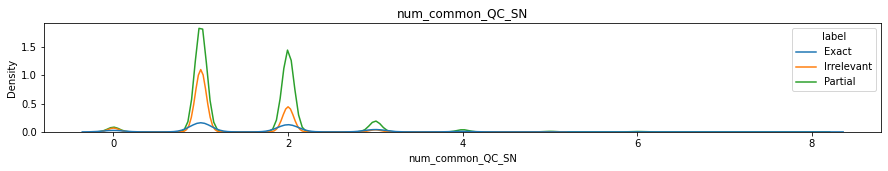

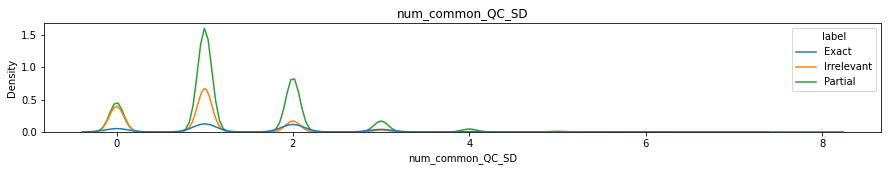

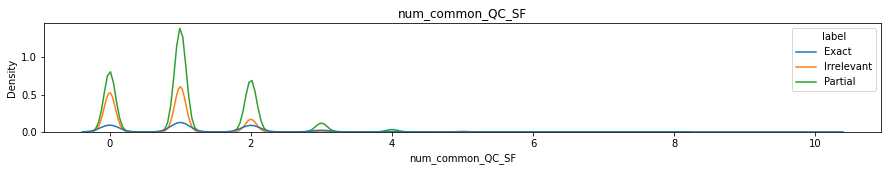

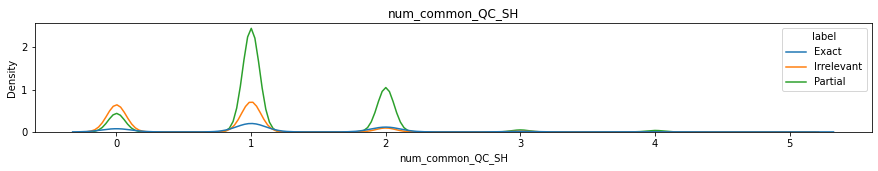

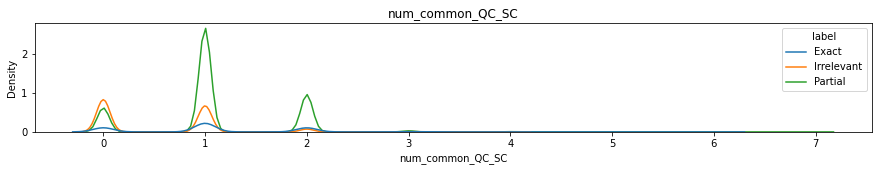

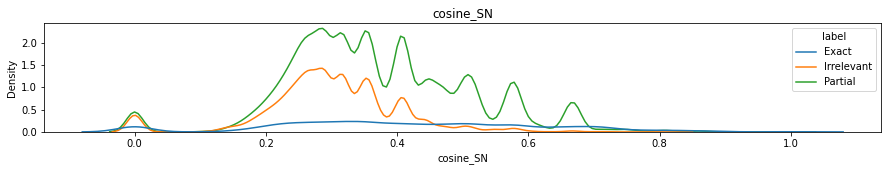

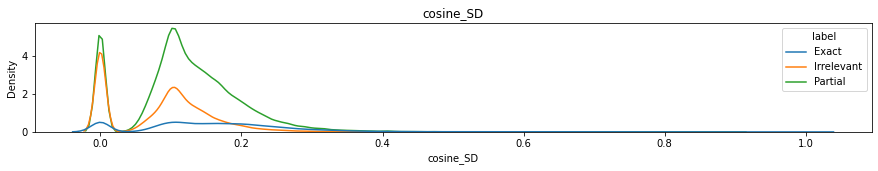

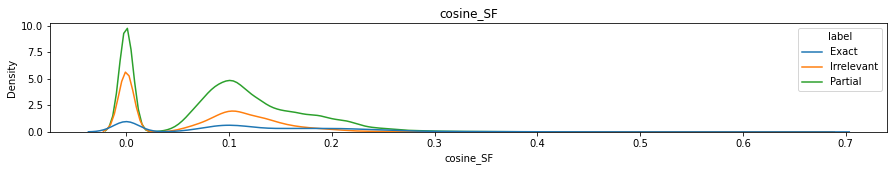

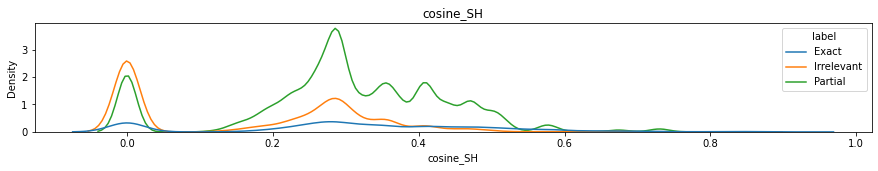

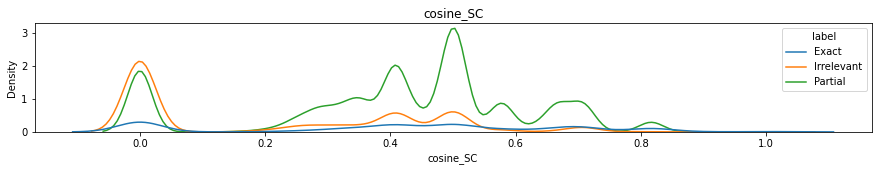

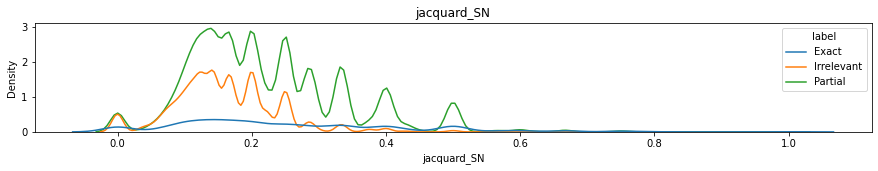

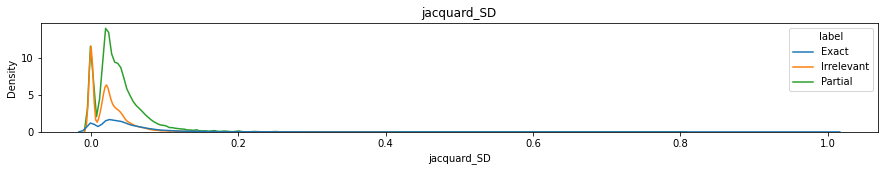

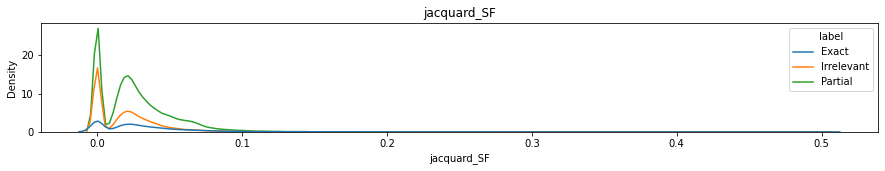

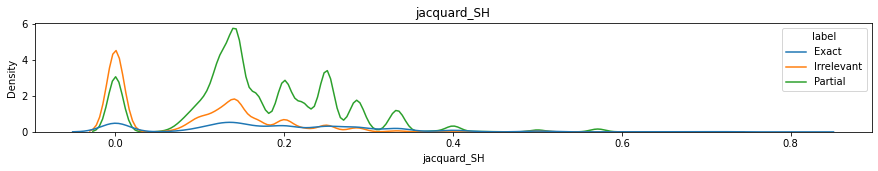

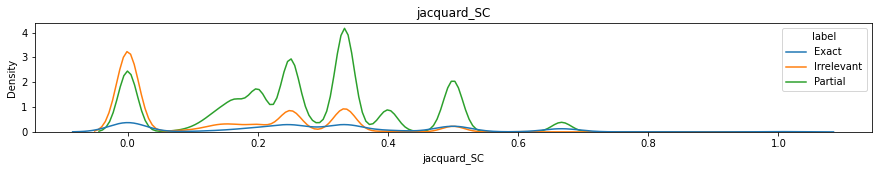

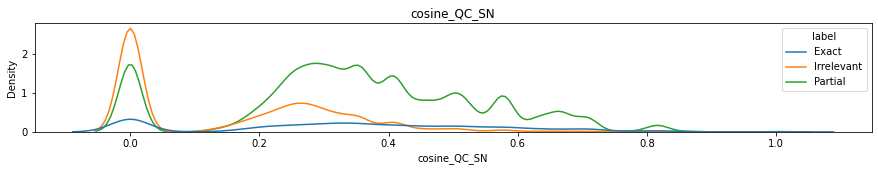

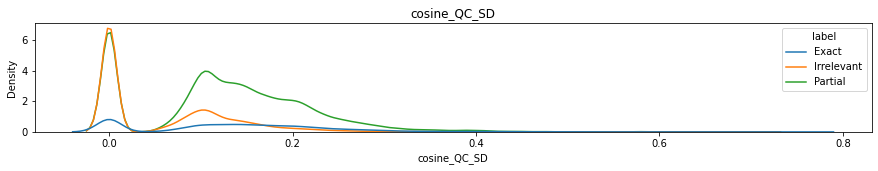

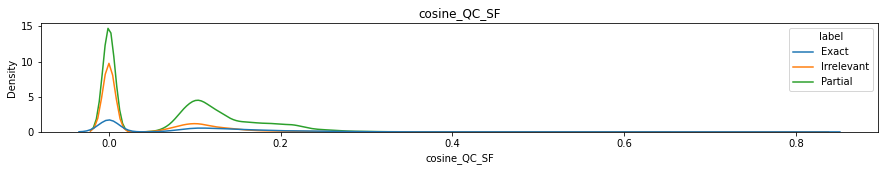

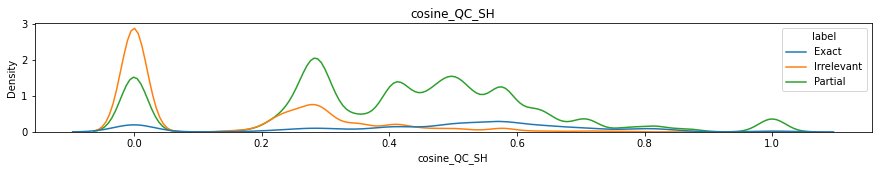

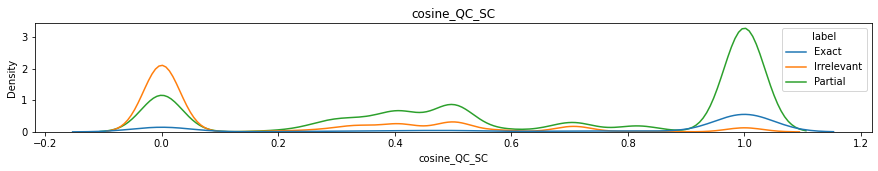

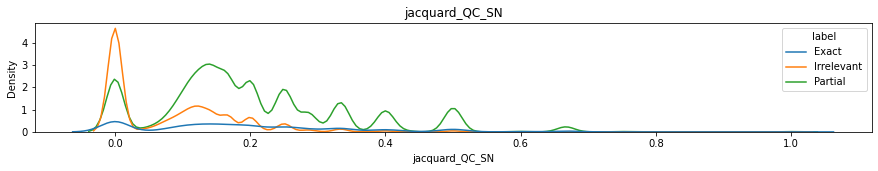

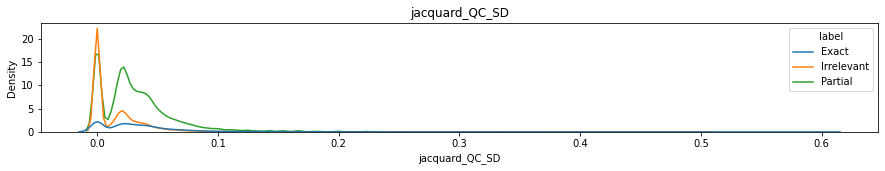

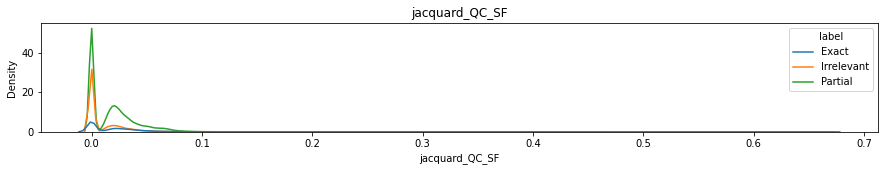

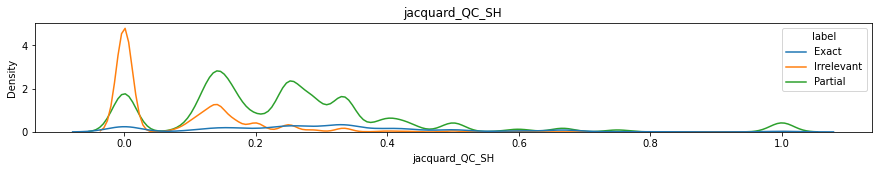

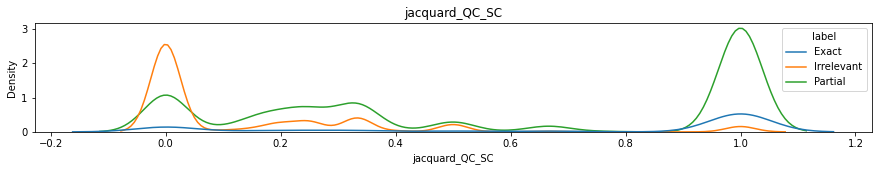

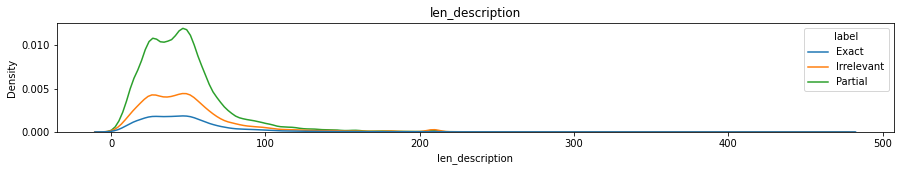

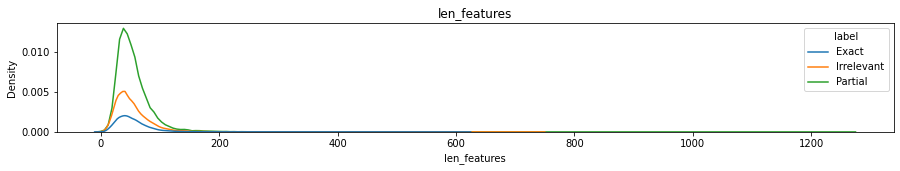

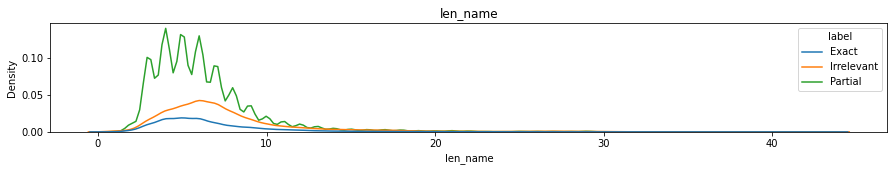

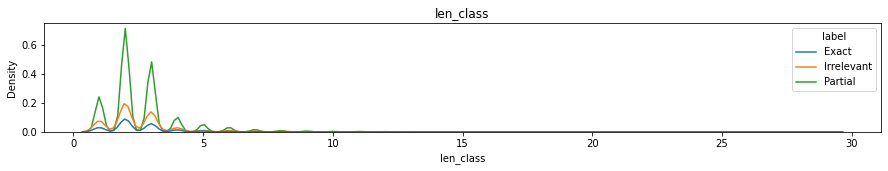

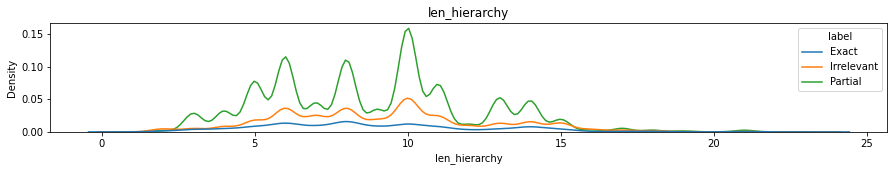

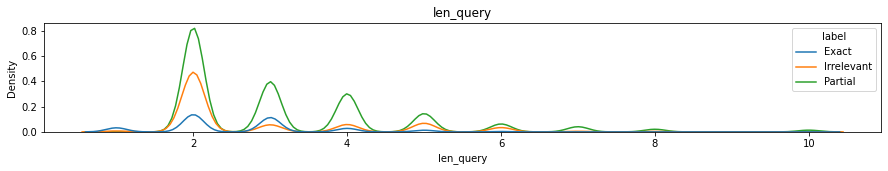

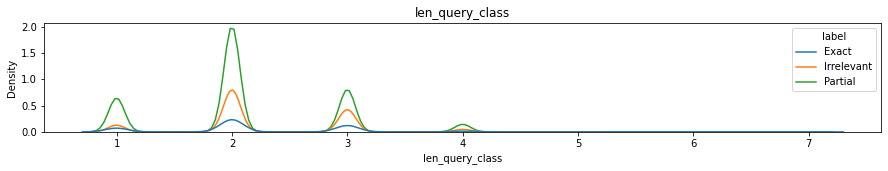

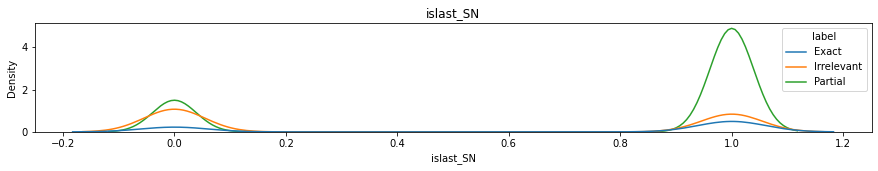

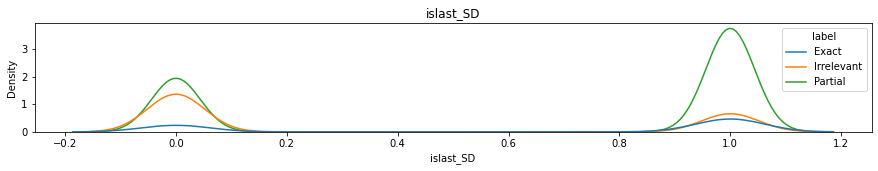

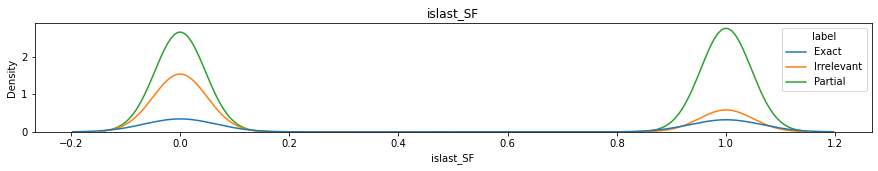

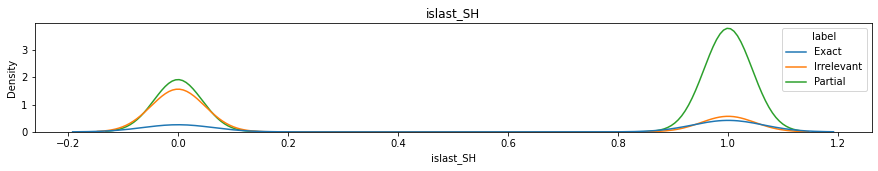

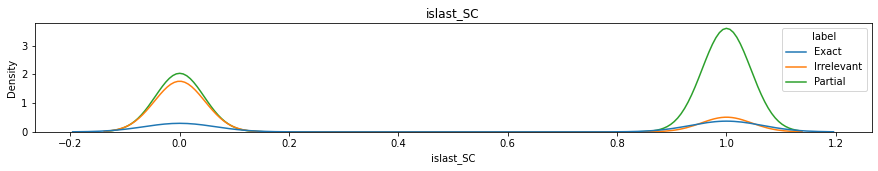

In [21]:
for col in feat_set1:
  plt.figure(figsize=(15,2))
  sns.kdeplot(data=eda_df1, x=col, hue="label")
  plt.title(col)
  plt.show()

Observations


*   List item

*   List item
*   List item


*   List item



### CORRELATION MATRIX 

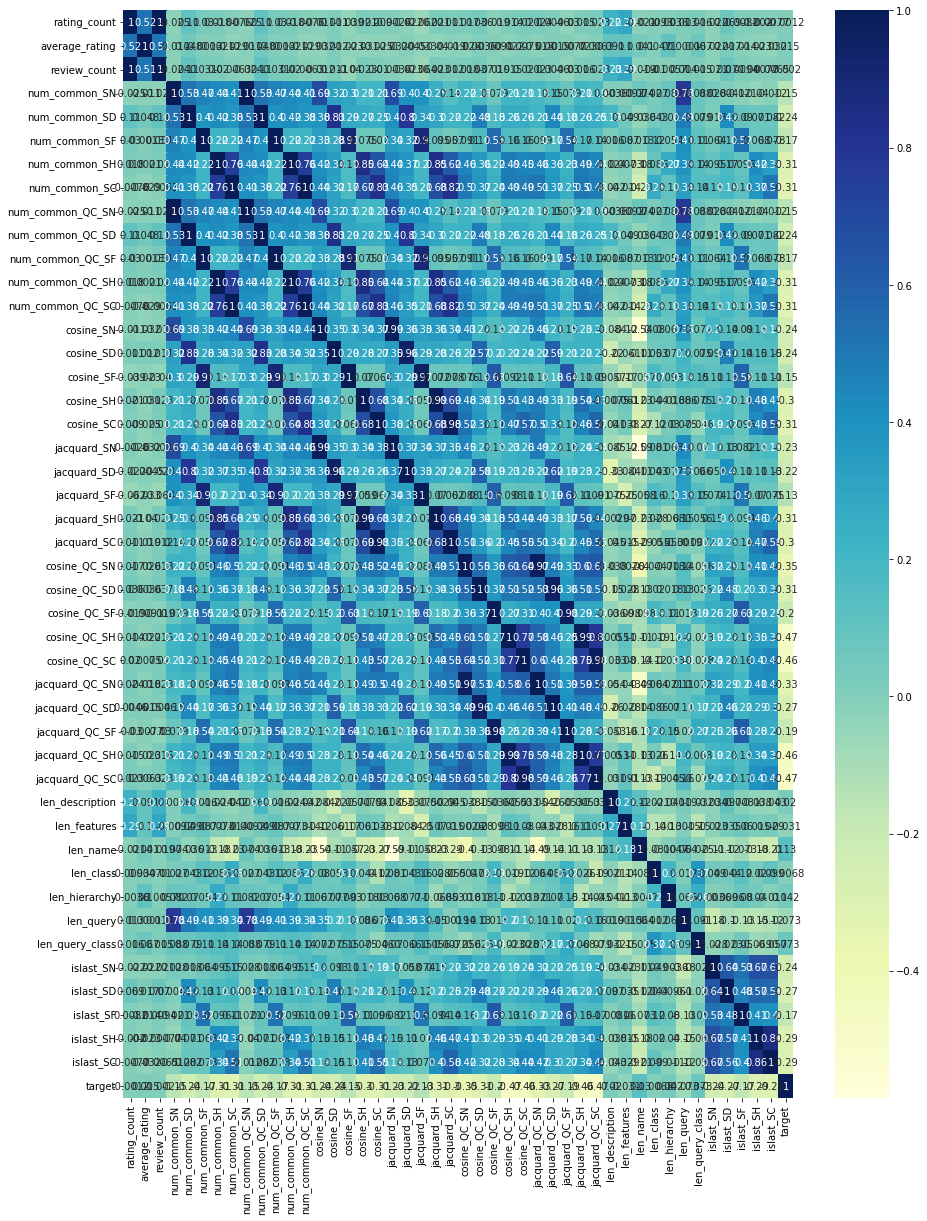

In [22]:


# plotting correlation heatmap
plt.figure(figsize=(15,20))
corr_df = eda_df.corr(method='spearman')
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()



In [23]:
thresh = 0.8
t1 = corr_df.abs()
t1 = t1.unstack()
T = t1.sort_values(kind="quicksort")
print('Features with correlation greater than {}'.format(thresh))
print(T[(T>thresh) & (T<1.0)].drop_duplicates())

Features with correlation greater than 0.8
num_common_SC     jacquard_SC         0.822355
cosine_SD         num_common_QC_SD    0.829423
num_common_SC     cosine_SC           0.829648
jacquard_SH       num_common_SH       0.851102
num_common_SH     cosine_SH           0.853573
islast_SC         islast_SH           0.859027
num_common_QC_SF  jacquard_SF         0.899058
num_common_SF     cosine_SF           0.907382
cosine_SD         jacquard_SD         0.956048
jacquard_QC_SD    cosine_QC_SD        0.959957
jacquard_SF       cosine_SF           0.967279
jacquard_QC_SN    cosine_QC_SN        0.972285
jacquard_QC_SC    cosine_QC_SC        0.976326
cosine_QC_SF      jacquard_QC_SF      0.980536
jacquard_SC       cosine_SC           0.981146
jacquard_SN       cosine_SN           0.986955
cosine_QC_SH      jacquard_QC_SH      0.987654
cosine_SH         jacquard_SH         0.990005
rating_count      review_count        0.997274
dtype: float64


There are a few highly correlated features. These correlated features can be redundant and hence we can try removing these highly correlated features.
We will omit them .

num_common_SC  
num_common_QC_SD   
num_common_SC      
jacquard_SH  
cosine_SH           
islast_SC          
num_common_QC_SF       
num_common_SF        
cosine_SD        
jacquard_QC_SD     
jacquard_SF        
jacquard_QC_SN,      




In [24]:
print('Most correlated features to relevance')
print('-'*50)
corr_df.abs()['target'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


target              1.000000
cosine_QC_SH        0.473344
jacquard_QC_SC      0.469610
cosine_QC_SC        0.461853
jacquard_QC_SH      0.460864
cosine_QC_SN        0.348178
jacquard_QC_SN      0.327368
num_common_QC_SC    0.314400
num_common_SC       0.314400
cosine_SC           0.312212
jacquard_SH         0.309807
cosine_QC_SD        0.306356
num_common_SH       0.306236
num_common_QC_SH    0.306236
jacquard_SC         0.304410
cosine_SH           0.297067
islast_SH           0.293797
islast_SC           0.291542
jacquard_QC_SD      0.272479
islast_SD           0.265405
cosine_SN           0.244216
cosine_SD           0.244138
islast_SN           0.239512
num_common_SD       0.237614
num_common_QC_SD    0.237614
jacquard_SN         0.227394
jacquard_SD         0.219577
cosine_QC_SF        0.204641
jacquard_QC_SF      0.189354
islast_SF           0.173909
num_common_SF       0.166211
num_common_QC_SF    0.166211
num_common_SN       0.149967
num_common_QC_SN    0.149967
cosine_SF     



*   

    The correlation scores are not very high but some correlation does exist.
    



*   We can see that correlation of 
cosine_QC_SH    ,
jacquard_QC_SC ,
cosine_QC_SC ,
jacquard_QC_SH   ,
cosine_QC_SN   ,
jacquard_QC_SN ,
num_common_QC_SC ,
num_common_SC   ,
cosine_SC     ,
jacquard_SH    
 are TOP 10




# Feature Set 2 - LSI similarity measures 

## FEATURES




*   Apply LSI on full text (combined name, class, hierarchy, features and description). Then, transform query and query class into the ‘concept’ space and calculate cosine similarity between them. Other similarity measure will be cosine coefficient, jacquard coefficient and inner product.





In [25]:


data2 = clean_df.copy()



NameError: ignored

In [ ]:
combined_doc = data2["name"].astype(str) + ' ' + data2["class"].astype(str)+ ' ' + data2["hierarchy"].astype(str) + ' ' +data2["description"].astype(str) + ' ' +data2["features"].astype(str)

vectorizer = TfidfVectorizer(smooth_idf=True, max_features=1000, min_df=2)
X_combined_doc = vectorizer.fit_transform(combined_doc)
print(X_combined_doc.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X_combined_doc)

tsvd_var_ratios = svd_model.explained_variance_ratio_
tsvd_var_ratios.sum()



In [ ]:
truncated_combined_doc = svd_model.transform(X_combined_doc)
print(truncated_combined_doc.shape)

X_search_ = vectorizer.transform(data2['query'])
print(X_search_.shape) # check shape of the document-term matrix

transformed_search = svd_model.transform(X_search_)
print(transformed_search.shape)





Calculating similarity between them


In [ ]:
def cosine_similarity_vec(a, b):
  """
  Cosine Similarity between 2 vectors
  """  
  num = np.dot(a, b)
  den = norm(a)*norm(b)
  if den != 0:
    return num/den
  else:
    return 0

def jacquard_similarity_vec(a, b):
  """
  Cosine Similarity between 2 vectors
  """  
  num = np.dot(a,b)
  den = norm(a)**2 + norm(b)**2 - np.dot(a,b)
  if den != 0:
    return num/den
  else:
    return 0

def inner_product_vec(a, b):
  return np.dot(a,b)



In [ ]:
cos_sim = []
for i in range(len(transformed_search)):
  cos_sim.append(cosine_similarity_vec(truncated_combined_doc[i], transformed_search[i]))
print(len(cos_sim))
data2['lsi_cos_sim'] = cos_sim



In [ ]:

jaq_sim = []
for i in range(len(transformed_search)):
  jaq_sim.append(jacquard_similarity_vec(truncated_combined_doc[i], transformed_search[i]))
print(len(jaq_sim))
data2['lsi_jaq_sim'] = jaq_sim


In [ ]:

inn_prod = []
for i in range(len(transformed_search)):
  inn_prod.append(inner_product_vec(truncated_combined_doc[i], transformed_search[i]))
print(len(inn_prod))
data2['lsi_inn_prod'] = inn_prod

In [ ]:

data2 = data2[['lsi_cos_sim', 'lsi_jaq_sim',	'lsi_inn_prod']]
print(data2.shape)
data2.head(3)

In [ ]:

eda_df2 = data2
eda_df2['target'] = clean_df['target']
# plotting correlation heatmap
corr_df = eda_df2[:4].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()

### Modeling 

In [ ]:
df = clean_df[]
df1 = data1['num_common_QC_SD','num_common_SC','cosine_SH','islast_SC','num_common_QC_SF','num_common_SF',
'cosine_SD','jacquard_QC_SD','jacquard_SF','num_common_SH']#omitting correlated features
df2 = data2[]# omitting correlated features
final_df = pd.concat([df1, df2], axis=1, ignore_index=False)
final_df.head()

In [ ]:
X1 = final_df.drop([ 'id','TID','FAILURE TYPE'], axis=1)  #tyre features
x = X1.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=X1.columns)
X = df.values
y = final_tmu_Df['FAILURE TYPE'].values 
le = LabelEncoder()
# le = le.fit(y)

# failure_dict = {0:"NORMAL", 1:"FAILURE"}

# y = le.fit_transform(y)
y = le.fit_transform(y)

with open(r'D:\CEAT\Failure algorithm\Code\Multiclass classification\Code\3.2.4\models\itam_failure_label_v3.2.4.sav','wb') as f:
    pickle.dump( le,f)
#%%
'pickle scaler to use later on validation sets'
import pickle 
with open(r'D:\CEAT\Failure algorithm\Code\Multiclass classification\Code\3.2.4\models\itam_failure_scaling_v3.2.4.sav','wb') as f:
    pickle.dump( min_max_scaler,f)

#%%
'Split data for modeling¶'

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print('Train values shape:', X_train.shape)
print('Test values shape:', X_test.shape)
print('Train target shape:', y_train.shape)
print('Test target shape:', y_test.shape)